In [5]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np

dl = DataLoader("/home/panda/rf_data/")

picmus_names = [
    "contrast_speckle_expe_dataset_rf",
    "contrast_speckle_simu_dataset_rf",
    "resolution_distorsion_expe_dataset_rf",
    "resolution_distorsion_simu_dataset_rf",
    "carotid_cross_expe_dataset_rf",
    "carotid_long_expe_dataset_rf"
]

#picmus_names = [ "contrast_speckle_expe_dataset_rf" ]
#picmus_names = [ "carotid_cross_expe_dataset_rf" ]
#picmus_names = [ "JHU028" ]
picmus_names = [ "TSH003" ]
#picmus_names = [ "UFL001", "UFL002", "UFL004", "UFL005", ]
#picmus_names = [ "INS007", "INS004" ]
#picmus_names = [ "INS004" ]
#picmus_names = [ "OSL007" ]


#picmus_names = [ "INS023", "INS018", "MYO001", "MYO003"]


nz = 2048
nx = 256



device = "cuda"
dtype = torch.float32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from deep_bf.wrapper import BenchmarkWrapper
from torch.profiler import profile, ProfilerActivity, schedule

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS",
    "MVB"
]

bf_names = ["MVB"]
#bf_names = ["DASGridSample"]

output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    angles_idx = np.arange(pw.n_angles)
    #angles_idx = np.array([0, 10, 32, 33, 60, 74])
    #angles_idx = np.array([32])

    f_num = 1.75
    window = "tukey25"

    with torch.profiler.profile(
        activities=[
            ProfilerActivity.CPU,
            ProfilerActivity.CUDA,
        ],
        record_shapes=True,
        profile_memory=True,
        with_stack=True,
        with_flops=False, 
    ) as prof:
        bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
        output[name] = bw.compute_reconstructions()
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=-1))


UFL001


KeyboardInterrupt: 

In [6]:
from deep_bf.wrapper import BenchmarkWrapper
from torch.profiler import profile, ProfilerActivity, schedule

def transform(rf):
    rf_max = rf / np.max(np.abs(rf))
    sigma = np.std(rf_max) + 1e-8
    rf = rf_max / sigma
    return rf

NEW_NS = 2300

def new_ns_fn(pw):
    if pw.n_samples <= NEW_NS:
        pw.data = np.pad(pw.data, pad_width=((0,0), (0,0), (0, NEW_NS - pw.n_samples)), mode='constant', constant_values=0)
    else:
        pw.data = pw.data[:, :, :NEW_NS]
        pw.img_depth = (NEW_NS / pw.fs) * (pw.c0 / 2)
    pw.n_samples = NEW_NS
    return pw

bf_names = [
    "DASGridSample",
    "DASManual",
    "FDMAS",
    "MVB"
]

#bf_names = ["MVB"]
#bf_names = ["DASGridSample"]
#bf_names = ["DASManual"]

bf_names = ["MVB", "DASGridSample"]

output = {}
for name in picmus_names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")

    #pw.data = transform(pw.data)
    #pw.c0 = 1540

    #print(pw)
    #pw.c0 = 1463
    angles_idx = np.arange(pw.n_angles)
    #angles_idx = np.array([0, 10, 32, 33, 60, 74])
    #angles_idx = np.array([pw.n_angles//2])
    #angles_idx = np.array([20])

    #pw = new_ns_fn(pw)

    #samples_idx = bw.get_samples_idx_by_angle(pw.n_angles//2)
    #print(samples_idx.isnan().sum())

    f_num = 1.75
    window = "tukey25"

    bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
    output[name] = bw.compute_reconstructions()


TSH003


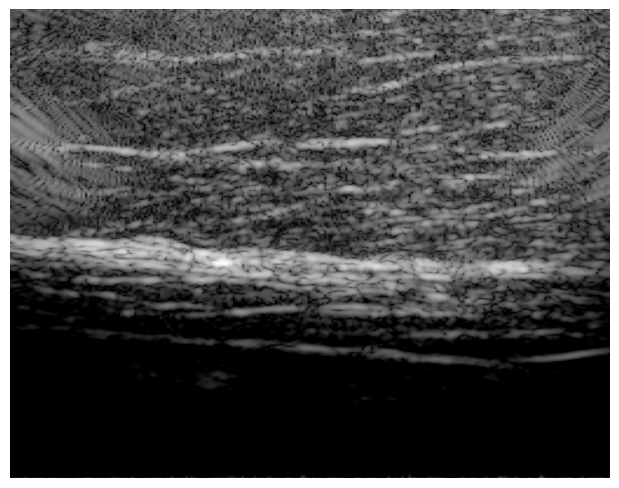

In [7]:
import matplotlib.pyplot as plt

#TODO: Revisar el data_loader y tratar de que sea igual al original de Hyun para verificar y que las imagenes sean las mismas
# que en el paper relacionado.

picmus_idx = 0
bf_idx = 0
o = output[picmus_names[picmus_idx]][bf_names[bf_idx]]

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = o.get_bmode(vmin=vmin, vmax=vmax)
extent = (o.xlims[0], o.xlims[-1], o.zlims[-1], o.zlims[0])


ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()

In [45]:
import torch
import torch.nn.functional as F

def _mad(x, dim=-1, keepdim=False, eps=1e-12):
    med = x.median(dim=dim, keepdim=True).values
    mad = (x - med).abs().median(dim=dim, keepdim=True).values
    mad = mad.clamp_min(eps)
    if keepdim:
        return med, mad
    return med.squeeze(dim), mad.squeeze(dim)

def _rolling_median_1d(x, win):
    pad = win // 2
    x2 = F.pad(x, (pad, pad), mode="replicate")
    xu = x2.unfold(-1, win, 1)
    return xu.median(dim=-1).values

def analyze_rf(
    rf,
    fs=None,
    f0=None,
    adc_max=None,
    spike_win=9,
    spike_thresh=8.0,
    clip_thresh=0.999,
    band_frac=(0.5, 1.5),
    depth_windows=((0.05, 0.15), (0.7, 0.9)),
    device=None,
):
    if device is not None:
        rf = rf.to(device)

    A, C, T = rf.shape
    x = rf
    x_abs = x.abs() if torch.is_complex(x) else x.abs()

    med, mad = _mad(x_abs, dim=-1, keepdim=True)
    z_robust = (x_abs - med).abs() / (1.4826 * mad)

    roll_med = _rolling_median_1d(x_abs, spike_win)
    spike_score = (x_abs - roll_med).abs() / (1.4826 * mad)
    spike_mask = spike_score > spike_thresh
    spike_rate = spike_mask.float().mean(dim=-1)

    if adc_max is None:
        peak = x_abs.amax(dim=-1, keepdim=True)
        clip_level = peak * clip_thresh
        clip_mask = x_abs >= clip_level
    else:
        clip_level = torch.tensor(float(adc_max), device=rf.device, dtype=x_abs.dtype) * clip_thresh
        clip_mask = x_abs >= clip_level

    clip_rate = clip_mask.float().mean(dim=-1)
    flat_diff = (x[..., 1:] - x[..., :-1]).abs()
    flat_rate = (flat_diff < (flat_diff.median() * 1e-3)).float().mean(dim=-1)

    dc = x.mean(dim=-1)
    dc_abs = dc.abs() if torch.is_complex(dc) else dc.abs()

    rms = torch.sqrt((x_abs ** 2).mean(dim=-1).clamp_min(1e-12))
    rms_med = rms.median(dim=1, keepdim=True).values
    rms_ratio = rms / rms_med.clamp_min(1e-12)

    if fs is not None:
        fs = float(fs)
        X = torch.fft.rfft(x if torch.is_complex(x) else x.to(torch.float32), dim=-1)
        P = (X.abs() ** 2)
        freqs = torch.fft.rfftfreq(T, d=1.0 / fs).to(rf.device)

        if f0 is None:
            band_mask = torch.ones_like(freqs, dtype=torch.bool)
        else:
            f0 = float(f0)
            fmin = band_frac[0] * f0
            fmax = band_frac[1] * f0
            band_mask = (freqs >= fmin) & (freqs <= fmax)

        P_band = P[..., band_mask]
        P_tot = P.sum(dim=-1).clamp_min(1e-12)
        band_energy_frac = P_band.sum(dim=-1) / P_tot

        Pm = P.median(dim=-1).values.clamp_min(1e-12)
        Ppk = P.amax(dim=-1).clamp_min(1e-12)
        narrowband_ratio = Ppk / Pm
    else:
        freqs = None
        band_energy_frac = None
        narrowband_ratio = None

    corr = None
    corr_outlier = None
    w0, w1 = depth_windows[0]
    i0 = int(round(w0 * T))
    i1 = int(round(w1 * T))
    i0 = max(0, min(T - 2, i0))
    i1 = max(i0 + 1, min(T - 1, i1))

    xw = x[..., i0:i1]
    xw = xw - xw.mean(dim=-1, keepdim=True)
    xw = xw / (xw.std(dim=-1, keepdim=True).clamp_min(1e-12))

    xw_flat = xw.reshape(-1, C, xw.shape[-1])
    corr = torch.einsum("bct,bdt->bcd", xw_flat, xw_flat.conj() if torch.is_complex(xw_flat) else xw_flat) / xw_flat.shape[-1]
    corr_abs = corr.abs() if torch.is_complex(corr) else corr.abs()
    corr_abs = corr_abs.mean(dim=0)
    corr_abs.fill_diagonal_(0.0)
    corr_max = corr_abs.amax(dim=-1)
    corr_outlier = corr_max > (corr_max.median() + 3.0 * (corr_max - corr_max.median()).abs().median().clamp_min(1e-12))

    flags = {
        "spiky_channels": (spike_rate.mean(dim=0) > 1e-4),
        "clipped_channels": (clip_rate.mean(dim=0) > 1e-4) | (flat_rate.mean(dim=0) > 0.05),
        "dead_or_weak_channels": (rms_ratio.median(dim=0).values < 0.3),
        "hot_channels": (rms_ratio.median(dim=0).values > 3.0),
        "dc_offset_channels": (dc_abs.median(dim=0).values > (dc_abs.median() + 5.0 * (dc_abs - dc_abs.median()).abs().median().clamp_min(1e-12))),
        "high_crosstalk_channels": corr_outlier,
    }

    if narrowband_ratio is not None:
        flags["narrowband_interference_channels"] = (narrowband_ratio.median(dim=0).values > 50.0)
    else:
        flags["narrowband_interference_channels"] = None

    report = {
        "spike_rate_per_angle_channel": spike_rate,
        "clip_rate_per_angle_channel": clip_rate,
        "flat_rate_per_angle_channel": flat_rate,
        "dc_per_angle_channel": dc,
        "rms_per_angle_channel": rms,
        "rms_ratio_per_angle_channel": rms_ratio,
        "band_energy_fraction_per_angle_channel": band_energy_frac,
        "narrowband_ratio_per_angle_channel": narrowband_ratio,
        "corr_matrix_mean_window": corr_abs,
        "flags": flags,
        "window_samples": (i0, i1),
        "freqs": freqs,
    }
    return report

def mitigate_rf(rf, spike_win=9, spike_thresh=8.0, highpass=True):
    x = rf
    x_abs = x.abs() if torch.is_complex(x) else x.abs()

    med, mad = _mad(x_abs, dim=-1, keepdim=True)
    roll_med = _rolling_median_1d(x_abs, spike_win)
    spike_score = (x_abs - roll_med).abs() / (1.4826 * mad)
    spike_mask = spike_score > spike_thresh

    x2 = x.clone()
    x2[spike_mask] = (roll_med[spike_mask] * x[spike_mask].sign()) if (not torch.is_complex(x)) else (roll_med[spike_mask] * x[spike_mask] / (x_abs[spike_mask].clamp_min(1e-12)))

    if highpass:
        x2 = x2 - x2.mean(dim=-1, keepdim=True)

    return x2

In [48]:
_rf = torch.from_numpy(pw.data)
report = analyze_rf(_rf, fs=pw.fs, f0=pw.fc, adc_max=None)
print(report["flags"])

{'spiky_channels': tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True]), 'clipped_channels': tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, Tru